---
title: Spectral Analysis
---

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import cvxpy as cp
import mosek

## Spectrum Model

We are working with the model: $\text{Re}(b_j), \text{Im}(b_j) \overset{\text{i.i.d}}{\sim} N(0, \gamma_j^2)$ for $j = 1, \dots, m$ (here $m = (n-1)/2$), where $b_0, \dots, b_{n-1}$ denote the DFT of the observed data $y_t$. The parameters underlying this model are $\gamma_1^2, \dots, \gamma_m^2$. The model can be written in terms of the periodogram $I(j/n)$ as
\begin{equation*}
   I(j/n) = \frac{|b_j|^2}{n} \overset{\text{ind}}{\sim} f(j/n) \eta_j
\end{equation*}
where $\eta_j \overset{\text{i.i.d}}{\sim} Exp(1)$. The mean of the periodogram $f(j/n)$ is called the power of frequency $j/n$. The relation between $f(j/n)$ and $\gamma_j$ is given by 
\begin{equation*}
   f(j/n) = \frac{2 \gamma_j^2}{n} ~~~ \text{ for } j = 1, \dots, m. 
\end{equation*}
If we treat $f(j/n)$ as a function on $[0, 1/2]$ (say by joining successive values by lines), we obtain the power spectral density function.

### Application One: Sunspots Dataset



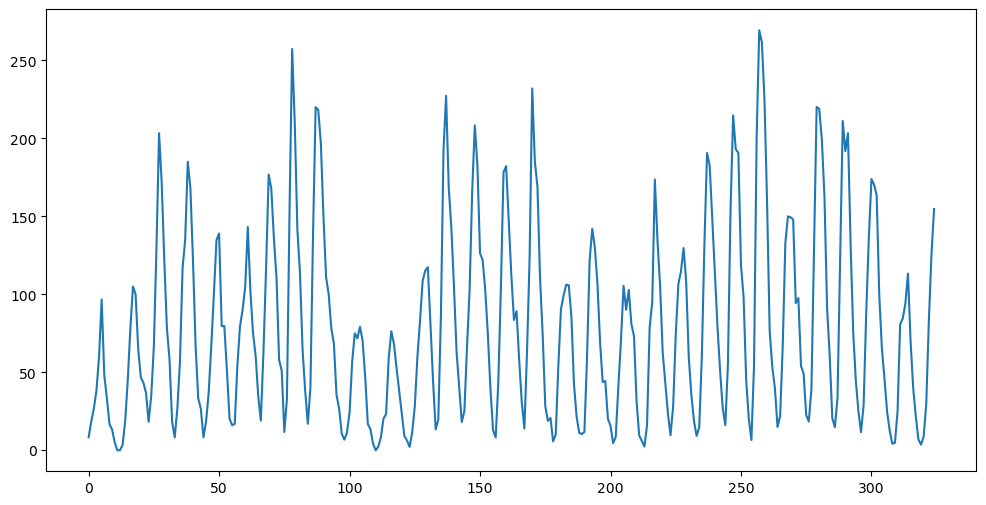

In [63]:
sunspots = pd.read_csv('SN_y_tot_V2.0.csv', header = None, sep = ';')
y = sunspots.iloc[:,1].values
n = len(y)
plt.figure(figsize = (12, 6))
plt.plot(y)
plt.show()

In [64]:
def periodogram(y):
    fft_y = np.fft.fft(y)
    n = len(y)
    fourier_freqs = np.arange(1/n, 1/2, 1/n)
    m = len(fourier_freqs)
    pgram_y = (np.abs(fft_y[1:m+1]) ** 2)/n
    return fourier_freqs, pgram_y

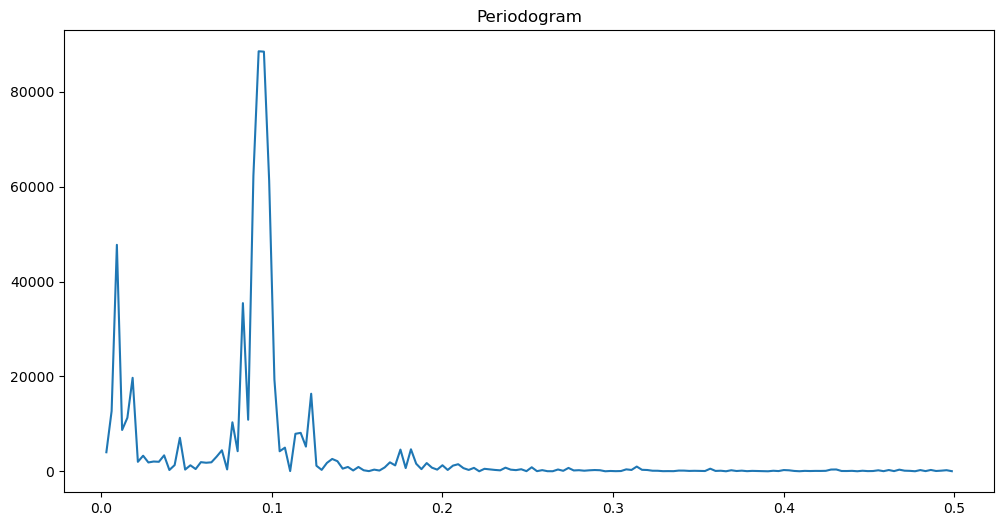

In [65]:
freqs, pgram = periodogram(y)
plt.figure(figsize = (12, 6))
plt.plot(freqs, pgram)
plt.title('Periodogram')
plt.show()

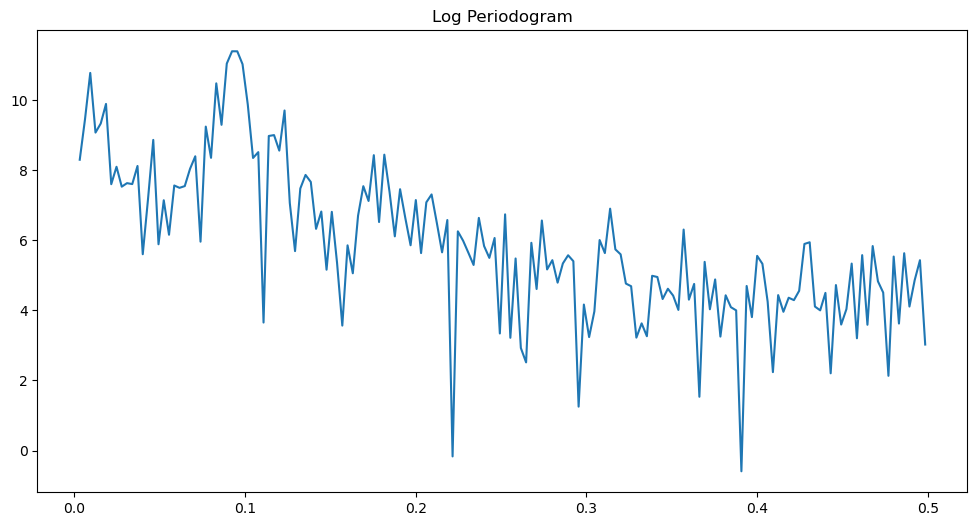

In [66]:
freqs, pgram = periodogram(y)
plt.figure(figsize = (12, 6))
plt.plot(freqs, np.log(pgram))
plt.title('Log Periodogram')
plt.show()

Note that the periodogram above is quite rough and wiggly (noisy). The spectrum model can be used to smooth it. With proper regularization, we will get estimates of the mean of the periodogram $f(j/n)$ which smooth the trend in the periodogram without being noisy. 

To estimate $\gamma_j, j = 1, \dots, m$ in the spectrum model, we use the following estimators (below $\alpha_j = \log \gamma_j$)
\begin{equation*}
   \sum_{j=1}^m \left( \frac{nI(j/n)}{2} e^{-2 \alpha_j} + 2 \alpha_j \right)  + \lambda \sum_{j=2}^{m-1} \left((\alpha_{j+1} - \alpha_j) - (\alpha_j - \alpha_{j-1}) \right)^2
\end{equation*}
or
\begin{equation*}
    \sum_{j=1}^m \left( \frac{nI(j/n)}{2} e^{-2 \alpha_j} + 2 \alpha_j \right) + \lambda \sum_{j=2}^{m-1} \left|(\alpha_{j+1} - \alpha_j) - (\alpha_j - \alpha_{j-1}) \right|.
\end{equation*}

In [67]:
def spectrum_estimator_ridge(y, lambda_val):
    freq, I = periodogram(y)
    m = len(freq)
    n = len(y)
    alpha = cp.Variable(m)
    neg_likelihood_term = cp.sum(cp.multiply((n * I / 2), cp.exp(-2 * alpha)) + 2*alpha)
    smoothness_penalty = cp.sum(cp.square(alpha[2:] - 2 * alpha[1:-1] + alpha[:-2]))
    objective = cp.Minimize(neg_likelihood_term + lambda_val * smoothness_penalty)
    problem = cp.Problem(objective)
    problem.solve(solver = cp.MOSEK)
    return alpha.value, freq

def spectrum_estimator_lasso(y, lambda_val):
    freq, I = periodogram(y)
    m = len(freq)
    n = len(y) 
    alpha = cp.Variable(m)
    neg_likelihood_term = cp.sum(cp.multiply((n * I / 2), cp.exp(-2 * alpha)) + 2*alpha)
    smoothness_penalty = cp.sum(cp.abs(alpha[2:] - 2 * alpha[1:-1] + alpha[:-2]))
    objective = cp.Minimize(neg_likelihood_term + lambda_val * smoothness_penalty)
    problem = cp.Problem(objective)
    problem.solve(solver = cp.MOSEK)
    return alpha.value, freq

The estimate of $\alpha_j$ can be converted to the power by 
\begin{equation*}
   f(j/n) = \mathbb{E} I(j/n) = \frac{2 \gamma_j^2}{n} = \frac{2}{n} e^{2 \alpha_j}
\end{equation*}

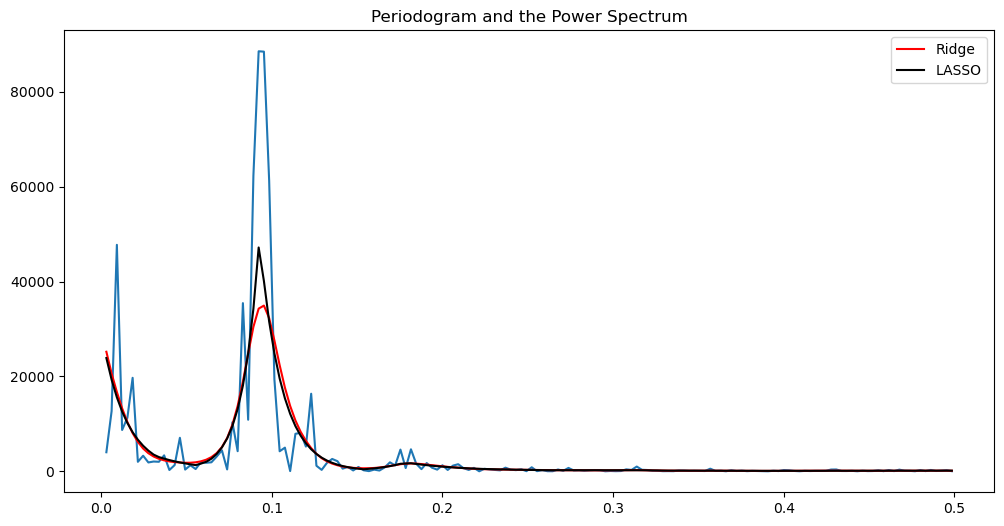

In [68]:
alpha_opt_ridge, freq = spectrum_estimator_ridge(y, 200)
power_ridge = (2/n)*(np.exp(2*alpha_opt_ridge))
alpha_opt_lasso, freq = spectrum_estimator_lasso(y, 10)
power_lasso = (2/n)*(np.exp(2*alpha_opt_lasso))

plt.figure(figsize = (12, 6))
#markerline, stemline, baseline = plt.stem(freq, pgram, linefmt = 'lightblue', basefmt = '')
#markerline.set_marker("None")
plt.plot(freq, pgram)
plt.title('Periodogram and the Power Spectrum')
plt.plot(freq, power_ridge, color = 'red', label = 'Ridge')
plt.plot(freq, power_lasso, color = 'black', label = "LASSO")
plt.legend()
plt.show()

#Mosek sometimes gives some format conversion warnings which you can ignore

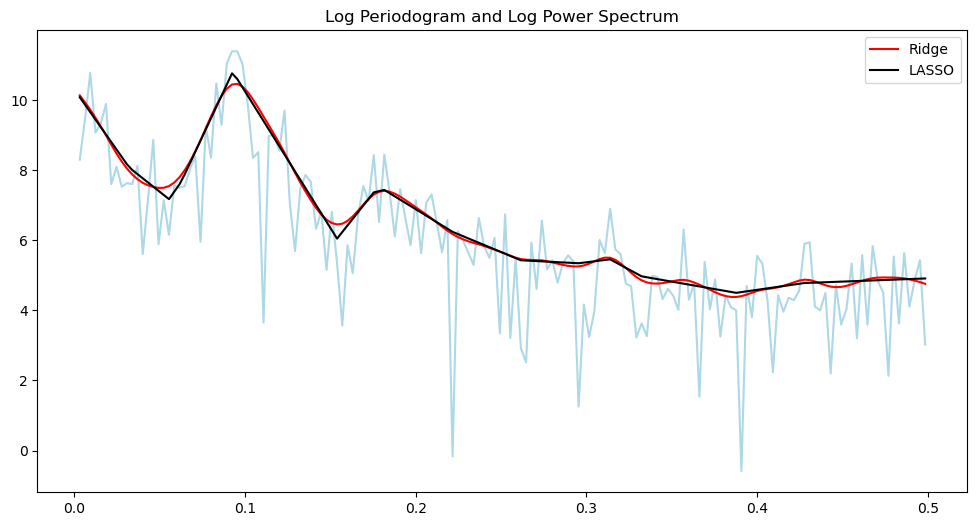

In [69]:
plt.figure(figsize = (12, 6))
#markerline, stemline, baseline = plt.stem(freq, np.log(pgram), linefmt = 'lightblue', basefmt = '')
#markerline.set_marker("None")
plt.plot(freq, np.log(pgram), color = 'lightblue')
plt.title('Log Periodogram and Log Power Spectrum')
plt.plot(freq, np.log(power_ridge), color = 'red', label = 'Ridge')
plt.plot(freq, np.log(power_lasso), color = 'black', label = "LASSO")
plt.legend()
plt.show()


There is a whole band of frequencies which contribute towards the mode in the power spectrum. 

### Application Two: Southern Oscillation Index Dataset

This dataset can be downloaded from http://www.bom.gov.au/climate/enso/soi/. El Niño (see wiki entry) is a climate pattern that describes the unusual warming of surface waters in the eastern tropical Pacific Ocean. It is believed to occur irregularly at two to seven year intervals. Closely related to the fluctuations in oceanic temperatures are large-scale changes in atmospheric pressure. El Nino events are associated with sustained negative Southern Oscillation Index (SOI) values. The SOI is computed from fluctuations in the surface air pressure difference between Tahiti and Darwin. See the paper "The definition of El Nino" by Trenberth 1997 for more details. 

Wikipedia article for El Niño Southern Oscillation has this sentence: "El Niño and Li Niña last a year or so and typically occur every two to seven years with varying intensity, with neutral periods of lower intensity interspersed."

In [70]:
def load_soi_data(filepath):
    data = []
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue  # skip blank lines if any
            
            date_str, soi_str = line.split(',')
            date_code = int(date_str)   # e.g. 187601
            year = date_code // 100     # e.g. 1876
            month = date_code % 100     # e.g. 1
            soi_val = float(soi_str)
            
            data.append([year, month, soi_val])
    
    # Create a DataFrame from parsed rows
    df = pd.DataFrame(data, columns=['Year', 'Month', 'SOI'])
    
    # Convert Year, Month to a datetime; assume day=1 for each month
    df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))
    
    # Make Date the index
    df.set_index('Date', inplace=True)
    
    # Sort by date just in case (and drop the now-redundant Year/Month columns)
    df.sort_index(inplace=True)
    
    return df[['SOI']]

# Usage
df_soi = load_soi_data("soi_monthly.txt")
print(df_soi)

             SOI
Date            
1876-01-01  11.3
1876-02-01  11.0
1876-03-01   0.2
1876-04-01   9.4
1876-05-01   6.8
...          ...
2024-10-01   4.2
2024-11-01   6.5
2024-12-01  10.8
2025-01-01   3.7
2025-02-01   3.0

[1790 rows x 1 columns]


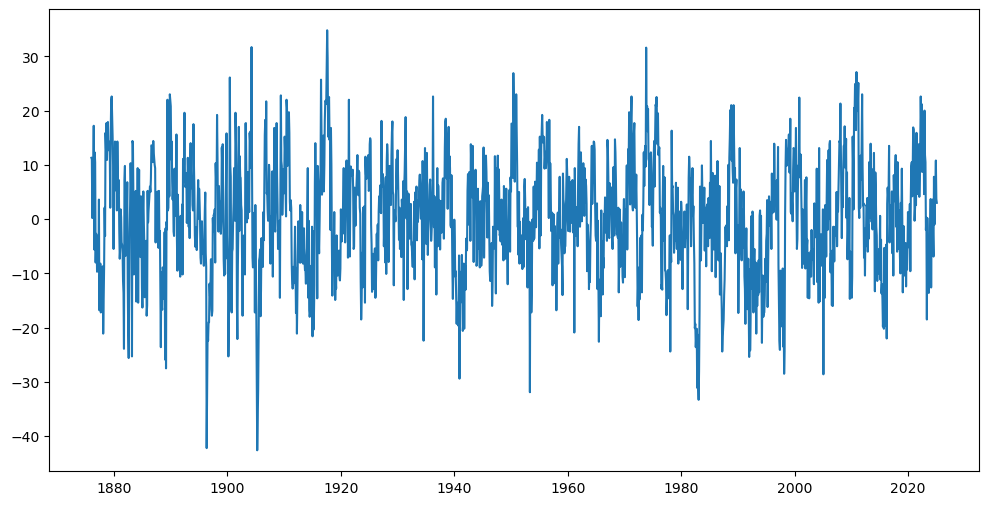

In [71]:
y = df_soi['SOI']
n = len(y)
plt.figure(figsize = (12, 6))
plt.plot(y)
plt.show()

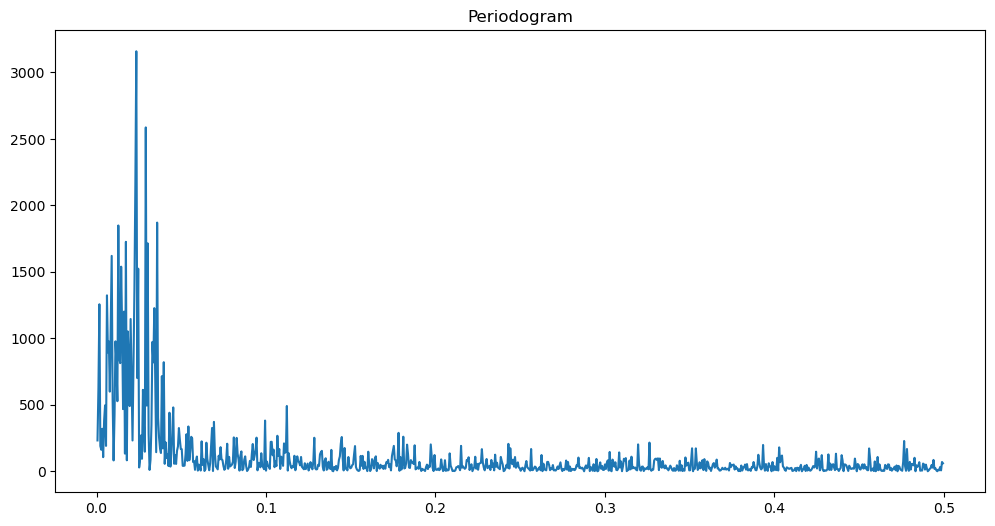

In [72]:
freqs, pgram = periodogram(y)
plt.figure(figsize = (12, 6))
plt.plot(freqs, pgram)
plt.title('Periodogram')
plt.show()

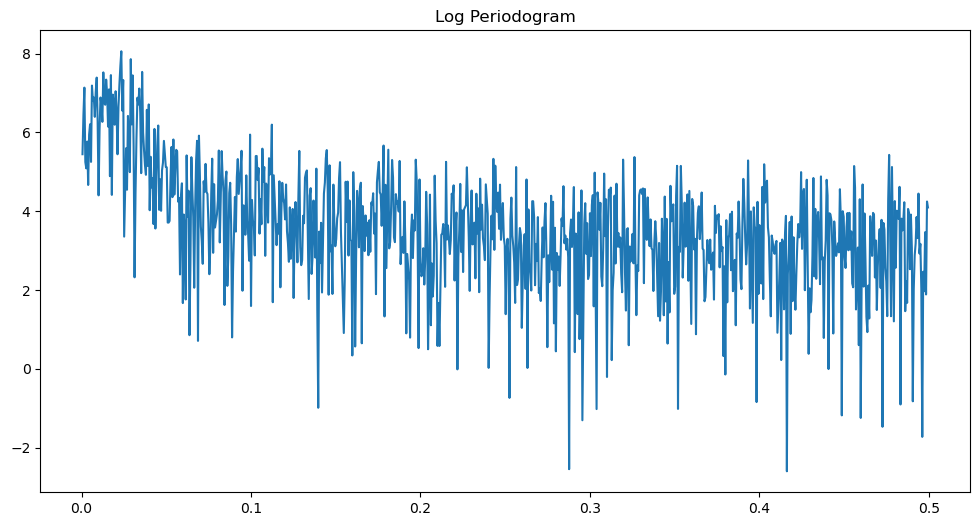

In [73]:
freqs, pgram = periodogram(y)
plt.figure(figsize = (12, 6))
plt.plot(freqs, np.log(pgram))
plt.title('Log Periodogram')
plt.show()

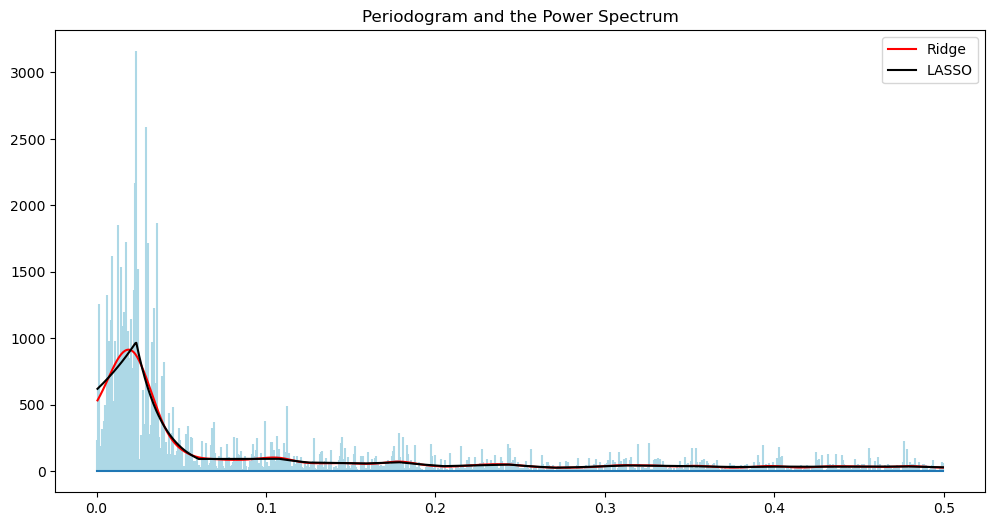

In [74]:
alpha_opt_ridge, freq = spectrum_estimator_ridge(y, 50000)
power_ridge = (2/n)*(np.exp(2*alpha_opt_ridge))
alpha_opt_lasso, freq = spectrum_estimator_lasso(y, 100)
power_lasso = (2/n)*(np.exp(2*alpha_opt_lasso))

plt.figure(figsize = (12, 6))
markerline, stemline, baseline = plt.stem(freq, pgram, linefmt = 'lightblue', basefmt = '')
markerline.set_marker("None")
plt.title('Periodogram and the Power Spectrum')
plt.plot(freq, power_ridge, color = 'red', label = 'Ridge')
plt.plot(freq, power_lasso, color = 'black', label = "LASSO")
plt.legend()
plt.show()


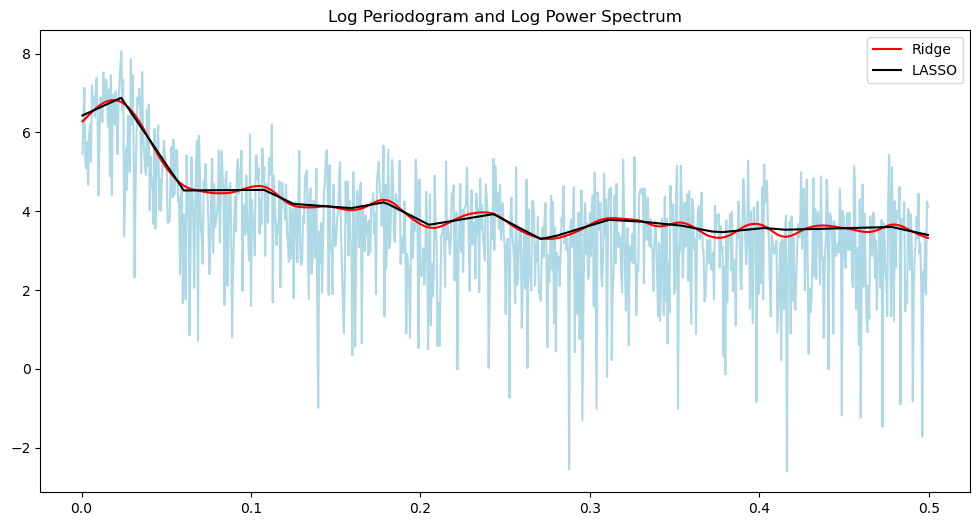

In [75]:
plt.figure(figsize = (12, 6))
#markerline, stemline, baseline = plt.stem(freq, np.log(pgram), linefmt = 'lightblue', basefmt = '')
#markerline.set_marker("None")
plt.plot(freq, np.log(pgram), color = 'lightblue')
plt.title('Log Periodogram and Log Power Spectrum')
plt.plot(freq, np.log(power_ridge), color = 'red', label = 'Ridge')
plt.plot(freq, np.log(power_lasso), color = 'black', label = "LASSO")
plt.legend()
plt.show()


In [76]:
from scipy.signal import find_peaks
# Find peaks
peaks, _ = find_peaks(np.log(power_ridge))
print("Peaks:", peaks)
print(1/freq[peaks])

Peaks: [ 33 186 257 318 423 560 631 710 782 857]
[52.64705882  9.57219251  6.9379845   5.61128527  4.22169811  3.19073084
  2.83227848  2.51758087  2.28607918  2.08624709]


The peak therefore corresponds to the period of about 52.64 months, which is about 4.5 years. 

### Application Three: Quake Vibration Dataset

This dataset is from the Mathworks (MATLAB) tutorial "Practical Introduction to Frequency-Domain Analysis" (see [this link](https://www.mathworks.com/help/signal/ug/practical-introduction-to-frequency-domain-analysis.html)). From this matlab tutorial: *Active Mass Driver (AMD) control systems are used to reduce vibration in a building under an earthquake. An active mass driver is placed on the top floor of the building and, based on displacement and acceleration measurements of the building floors, a control system sends signals to the driver so that the mass moves to attenuate ground disturbances. Acceleration measurements were recorded on the first floor of a three story test structure under earthquake conditions. Measurements were taken without the active mass driver control system (open loop condition), and with the active control system (closed loop condition).*

In [77]:
from scipy.io import loadmat
mat_dict = loadmat('quakevibration.mat')
print(mat_dict.keys())

dict_keys(['__header__', '__version__', '__globals__', 'gfloor1OL', 'gfloor1CL'])


In [78]:
gfloor1OL_array = mat_dict['gfloor1OL']
gfloor1CL_array = mat_dict['gfloor1CL']
print(gfloor1OL_array.shape)
print(gfloor1CL_array.shape)

(10000, 1)
(10000, 1)


In [79]:
y_ol = gfloor1OL_array.ravel()
y_cl = gfloor1CL_array.ravel()

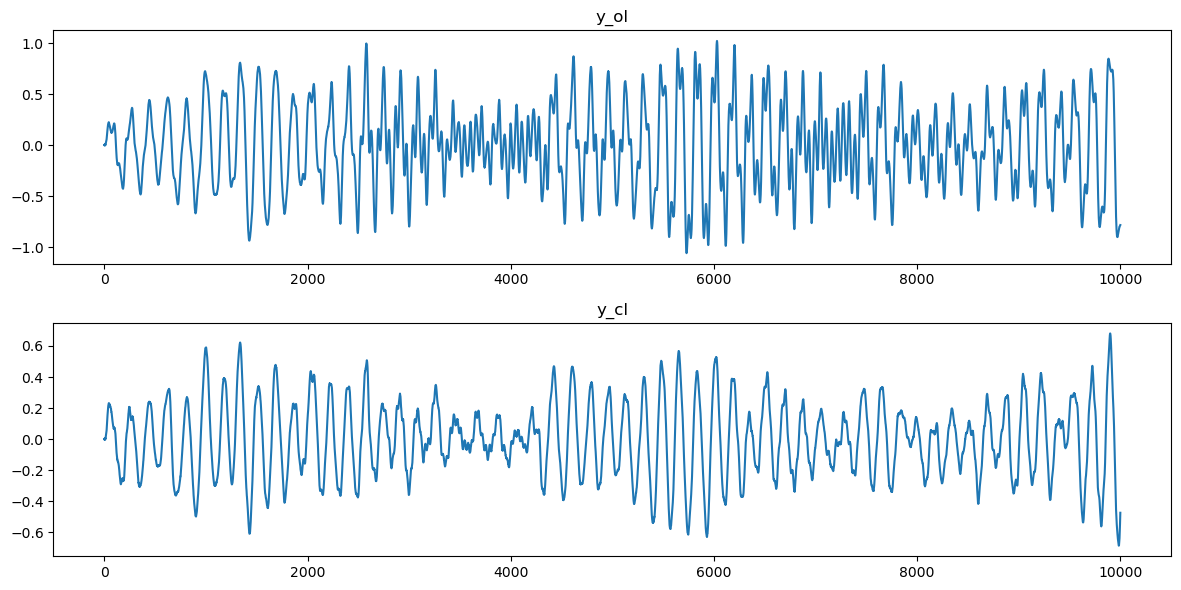

In [80]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))

axes[0].plot(y_ol)
axes[0].set_title('y_ol')

axes[1].plot(y_cl)
axes[1].set_title('y_cl')

plt.tight_layout()
plt.show()

In [81]:
n = len(y_ol)
freqs, pgram_ol = periodogram(y_ol)
alpha_opt_ridge_ol, freq = spectrum_estimator_ridge(y_ol, 100000)
pgram_mean_ridge_ol = (2/n)*(np.exp(2*alpha_opt_ridge_ol))
alpha_opt_lasso_ol, freq = spectrum_estimator_lasso(y_ol, 1000)
pgram_mean_lasso_ol = (2/n)*(np.exp(2*alpha_opt_lasso_ol))

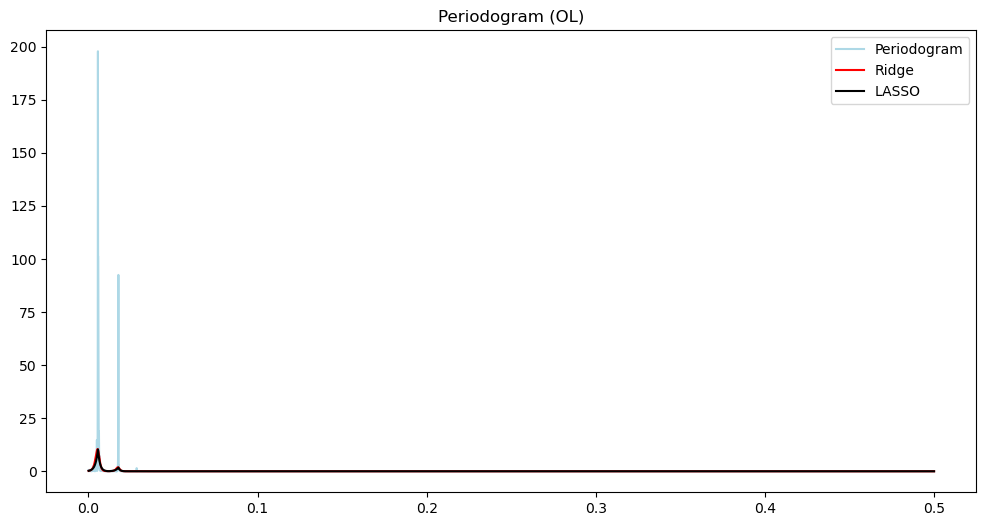

In [82]:
plt.figure(figsize = (12, 6))
plt.plot(freqs, (pgram_ol), color = 'lightblue', label = 'Periodogram')
#plt.plot(freqs, np.log(pgram_ol), color = 'None', label = 'Periodogram')
plt.title('Periodogram (OL)')
plt.plot(freqs, (pgram_mean_ridge_ol), color = 'red', label = 'Ridge')
plt.plot(freqs, (pgram_mean_lasso_ol), color = 'black', label = 'LASSO')
plt.legend()
plt.show()

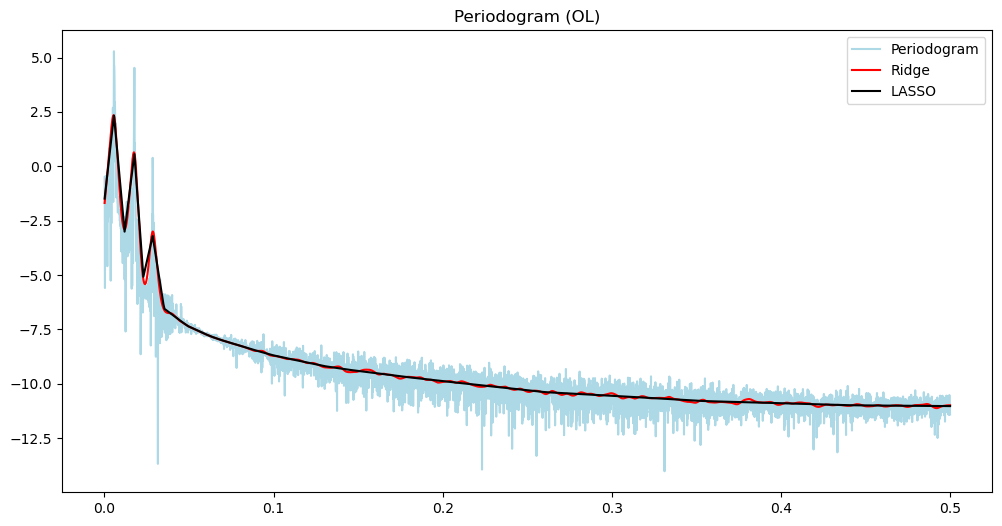

In [62]:
plt.figure(figsize = (12, 6))
plt.plot(freqs, np.log(pgram_ol), color = 'lightblue', label = 'Periodogram')
#plt.plot(freqs, np.log(pgram_ol), color = 'None', label = 'Periodogram')
plt.title('Periodogram (OL)')
plt.plot(freqs, np.log(pgram_mean_ridge_ol), color = 'red', label = 'Ridge')
plt.plot(freqs, np.log(pgram_mean_lasso_ol), color = 'black', label = 'LASSO')
plt.legend()
plt.show()

In [83]:
n = len(y_cl)
freqs, pgram_cl = periodogram(y_cl)
alpha_opt_ridge_cl, freq = spectrum_estimator_ridge(y_cl, 100000)
pgram_mean_ridge_cl = (2/n)*(np.exp(2*alpha_opt_ridge_cl))
alpha_opt_lasso_cl, freq = spectrum_estimator_lasso(y_cl, 1000)
pgram_mean_lasso_cl = (2/n)*(np.exp(2*alpha_opt_lasso_cl))

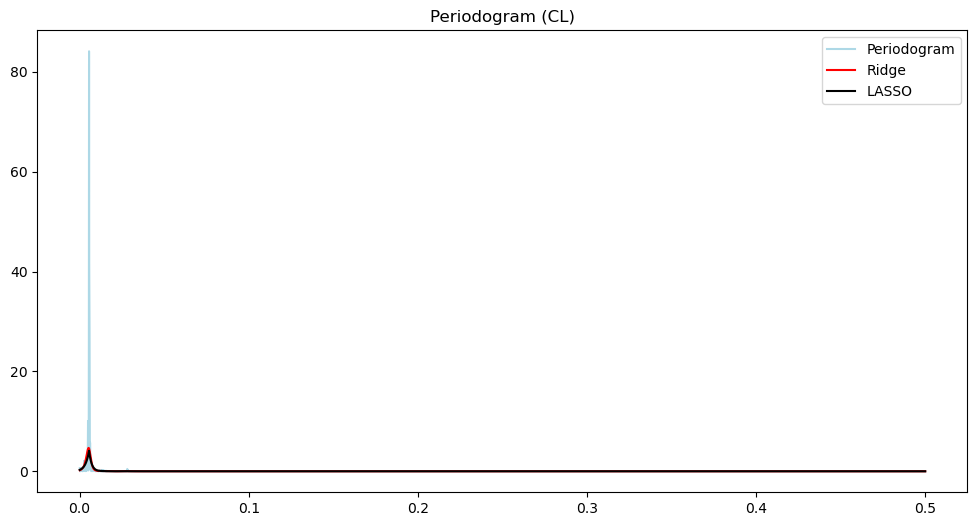

In [84]:
plt.figure(figsize = (12, 6))
plt.plot(freqs, (pgram_cl), color = 'lightblue', label = 'Periodogram')
#plt.plot(freqs, np.log(pgram_cl), color = 'None', label = 'Periodogram')
plt.title('Periodogram (CL)')
plt.plot(freqs, (pgram_mean_ridge_cl), color = 'red', label = 'Ridge')
plt.plot(freqs, (pgram_mean_lasso_cl), color = 'black', label = 'LASSO')
plt.legend()
plt.show()

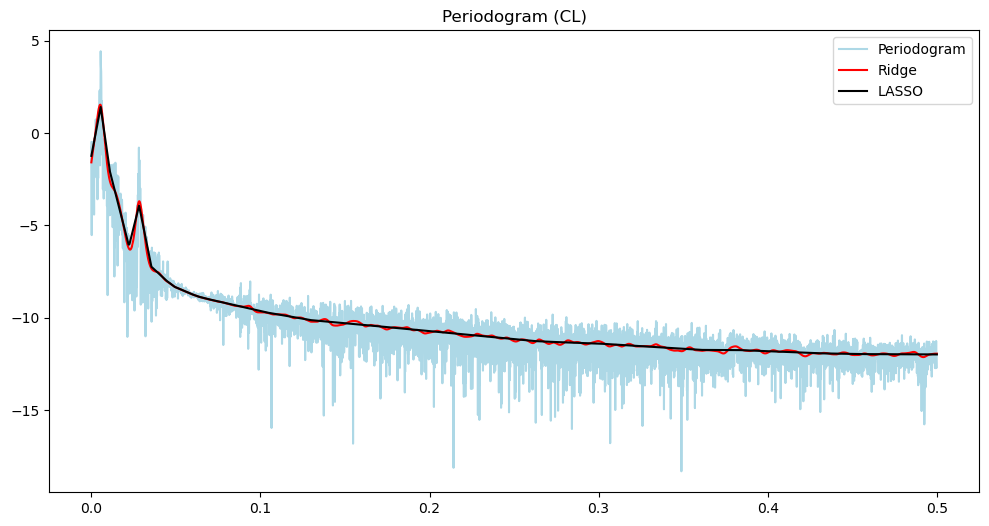

In [85]:
plt.figure(figsize = (12, 6))
plt.plot(freqs, np.log(pgram_cl), color = 'lightblue', label = 'Periodogram')
#plt.plot(freqs, np.log(pgram_cl), color = 'None', label = 'Periodogram')
plt.title('Periodogram (CL)')
plt.plot(freqs, np.log(pgram_mean_ridge_cl), color = 'red', label = 'Ridge')
plt.plot(freqs, np.log(pgram_mean_lasso_cl), color = 'black', label = 'LASSO')
plt.legend()
plt.show()

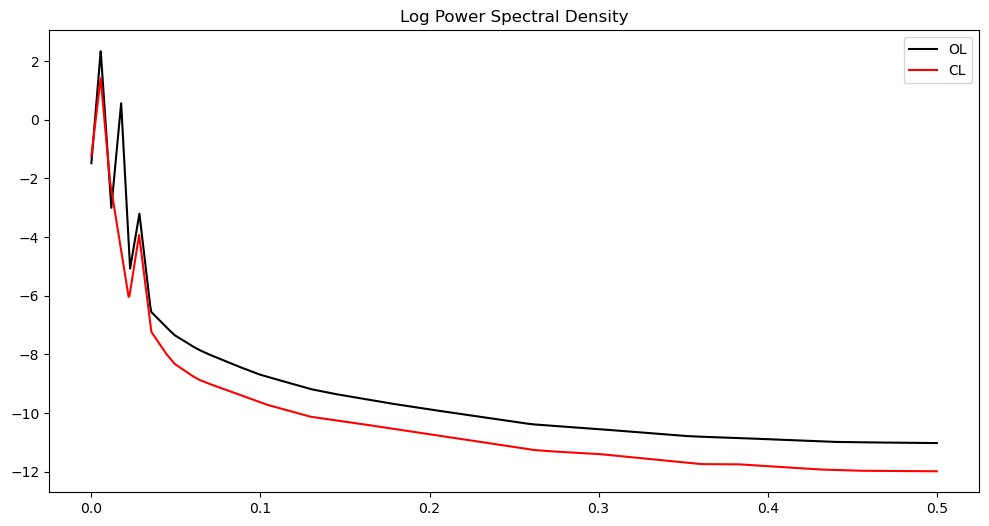

In [86]:
plt.figure(figsize = (12, 6))
plt.plot(freqs, np.log(pgram_mean_lasso_ol), color = 'black', label = 'OL')
plt.plot(freqs, np.log(pgram_mean_lasso_cl), color = 'red', label = 'CL')
plt.legend()
plt.title('Log Power Spectral Density')
plt.show()

There are three loops on the open loop spectrum and two on the closed loop spectrum. The control system reduces the overall power of the vibrations and gets rid of one harmonic component. In other words, the control system not only reduces the vibration but also brings it closer to a sinusoid. 

The main point is that the differences between the two time series is much better summarized using their power spectra, compared to the raw data. 

### Application Four: FRED dataset

The following datset is FRED's "Industrial Production: Total Index" dataset. It is a monthly dataset $I_t$ that is **not** seasonally adjusted. 

  observation_date  IPB50001N
0       1919-01-01     4.7841
1       1919-02-01     4.5959
2       1919-03-01     4.4884
3       1919-04-01     4.5691
4       1919-05-01     4.7035
5       1919-06-01     4.9991
6       1919-07-01     5.1604
7       1919-08-01     5.2679
8       1919-09-01     5.2947
9       1919-10-01     5.2679


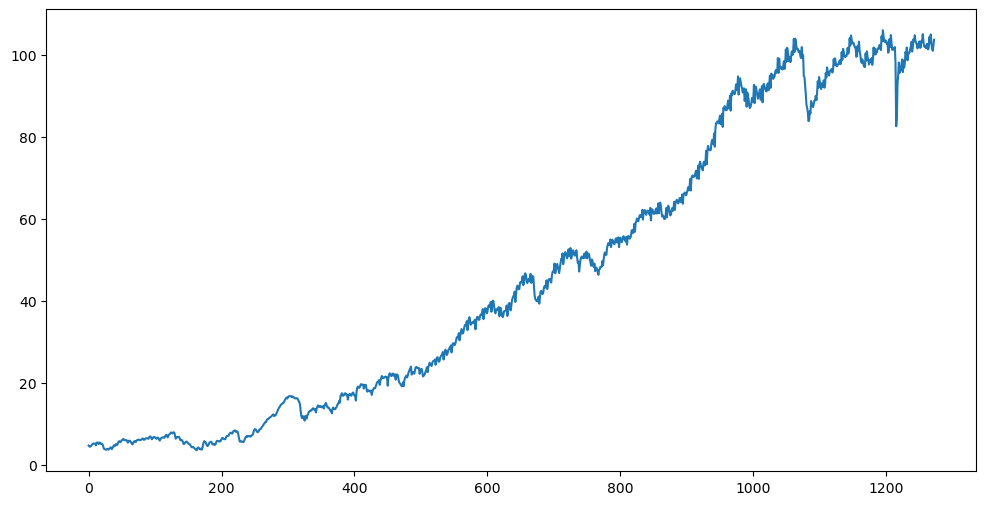

In [87]:
prod_index = pd.read_csv("IPB50001N-06March2025FRED.csv")
print(prod_index.head(10))
pind = prod_index['IPB50001N']
plt.figure(figsize = (12, 6))
plt.plot(pind)
plt.show()

The data has an increasing trend so it does not make sense to use the spectrum model directly here. Instead, let us work with the annual growth rates: 
\begin{equation*}
   y_t = 100 \left(\log I_t - \log I_{t-12} \right)
\end{equation*}

1261


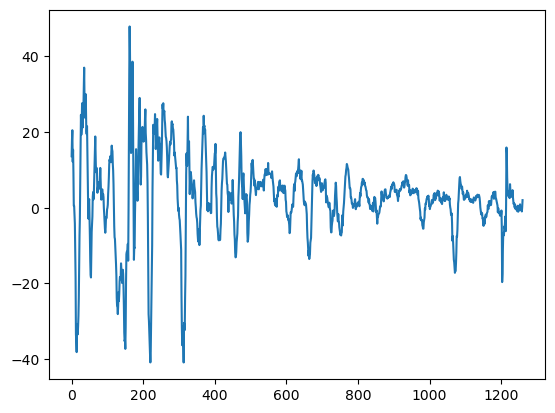

In [88]:
pind = prod_index['IPB50001N']
pind = pind.to_numpy()
y = 100*(np.log(pind[12:]) - np.log(pind[:-12]))
plt.plot(y)
n = len(y)
print(n) #now n is odd
plt.show()

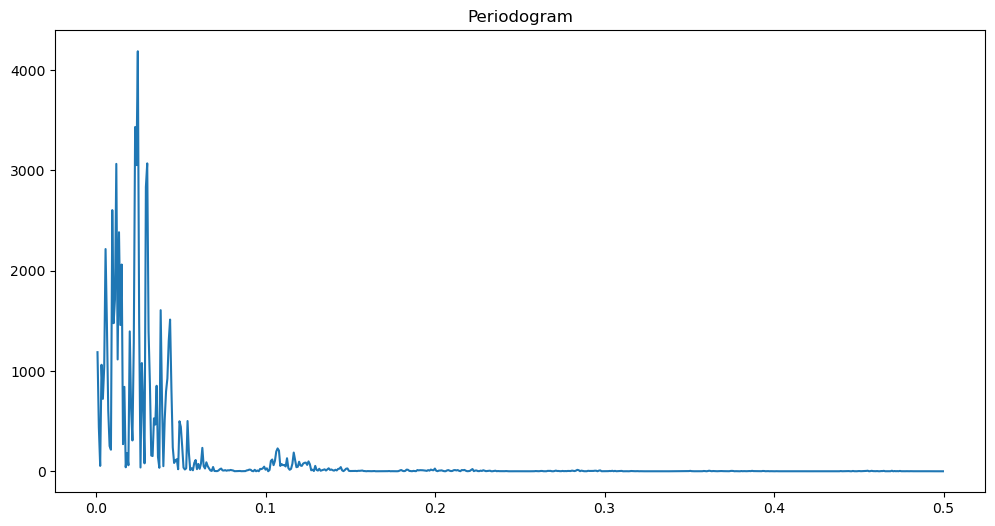

In [89]:
freqs, pgram = periodogram(y)
plt.figure(figsize = (12, 6))
plt.plot(freqs, pgram)
plt.title('Periodogram')
plt.show()

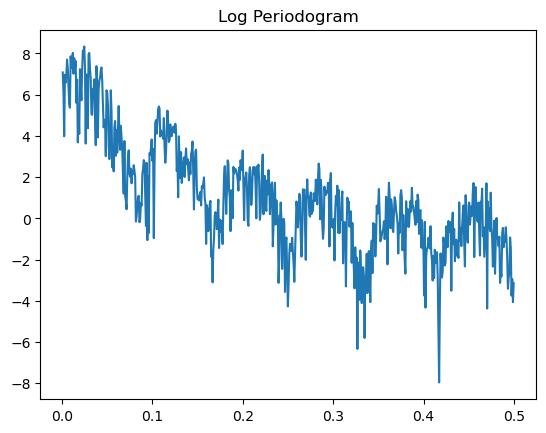

In [90]:
freqs, pgram = periodogram(y)
plt.plot(freqs, np.log(pgram))
plt.title('Log Periodogram')
plt.show()

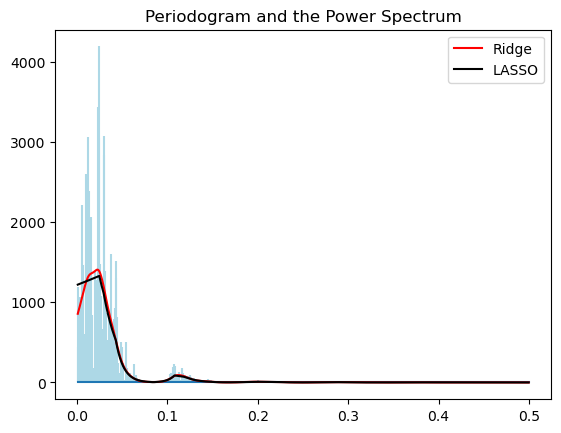

In [91]:
alpha_opt_ridge, freq = spectrum_estimator_ridge(y, 5000)
power_ridge = (2/n)*(np.exp(2*alpha_opt_ridge))
alpha_opt_lasso, freq = spectrum_estimator_lasso(y, 100)
power_lasso = (2/n)*(np.exp(2*alpha_opt_lasso))

markerline, stemline, baseline = plt.stem(freq, pgram, linefmt = 'lightblue', basefmt = '')
markerline.set_marker("None")
plt.title('Periodogram and the Power Spectrum')
plt.plot(freq, power_ridge, color = 'red', label = 'Ridge')
plt.plot(freq, power_lasso, color = 'black', label = "LASSO")
plt.legend()
plt.show()


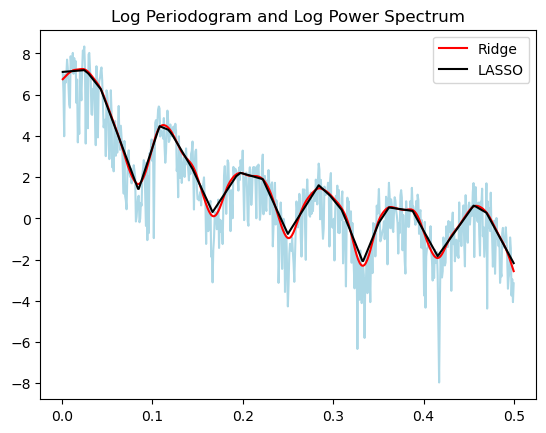

In [92]:
plt.plot(freq, np.log(pgram), color = 'lightblue')
plt.title('Log Periodogram and Log Power Spectrum')
plt.plot(freq, np.log(power_ridge), color = 'red', label = 'Ridge')
plt.plot(freq, np.log(power_lasso), color = 'black', label = "LASSO")
plt.legend()
plt.show()


In [93]:
from scipy.signal import find_peaks
# Find peaks
peaks, _ = find_peaks(np.log(power_ridge))
print("Peaks:", peaks)
print(freq[peaks])
print(1/freq[peaks])

Peaks: [ 27 140 248 266 358 458 484 577]
[0.0222046  0.11181602 0.19746233 0.21173672 0.28469469 0.36399683
 0.38461538 0.45836638]
[45.03571429  8.94326241  5.06425703  4.72284644  3.51253482  2.74727669
  2.6         2.1816609 ]


Economists use this as evidence for existence of a business cycle with period around 45 months (which is close to 4 years). See Section 6.4 for the Hamilton book on time series for more on this example. 